### Predict fovea and optic disc location in fundus images

In [2]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision.transforms import Compose, ToTensor, Resize, CenterCrop
from fundus_fovea_od_localization import ODFoveaLoader, ODFoveaModel, load_fovea_od_model, DEFAULT_CONFIG

#### **Option 1**: Train a model 
Skip to only evaluate a model or run inference. See below!

Load default config and adjust as desired. If replicating the original model, keep the parameters as they are except for data_root, which should point to the folder that contains the datasets ADAM, REFUGE and IDRID.

In [2]:
config = DEFAULT_CONFIG
config

namespace(batch_size=8,
          csv_path='/gpfs01/berens/user/jgervelmeyer/fundus_image_toolbox/fundus_fovea_od_localization/fundus_fovea_od_localization/data/ADAM+IDRID+REFUGE_df.csv',
          data_root='../../',
          device='cuda:0',
          epochs=500,
          img_size=350,
          lr=0.0001,
          model_type='efficientnet-b3',
          seed=123,
          testset_eval=True)

In [3]:
config.data_root = "/gpfs01/berens/user/jgervelmeyer/fovea_detection/"
config.epochs = 1

In [4]:
train_dataloader, val_dataloader, test_dataloader = ODFoveaLoader(config).get_dataloaders()

Train dataset: 948
Val dataset: 316
Test dataset: 317


In [6]:
model = ODFoveaModel(config)

Initializing efficientnet-b3 on cuda:0


In [1]:
model.train(train_dataloader, val_dataloader)

#### **Option 2**: Evaluate on the test set -or- run inference on images<br>
- Evaluation: Set `evaluate = True` and optionally set `plot = True` to plot the a grid of test set images with their predictions
- Inference: Set `inference = True` and ignore the other parameters

In [3]:
inference = True
evaluate = False
plot = False
device = "cuda:0"

# Choose your model:
#  - "default" for the authors' model
#  - "latest" for the latest model. If you trained a model, this is yours.
#  - or a specific path to the directory containing a checkpoint
checkpoint_dir = "default" 

In [4]:
if evaluate and not inference:    
    print("Loading model")
    model, checkpoint_path, test_dataloader = load_fovea_od_model(checkpoint_dir, device=device, return_test_dataloader=True)
    print(checkpoint_path)
    if evaluate:
        print("Evaluating model")
        model.evaluate(test_dataloader, checkpoint_path)
    
else:
    print("Loading model")
    model, checkpoint_path = load_fovea_od_model(checkpoint_dir, device=device, return_test_dataloader=False)
    print(checkpoint_path)

if plot and not inference:
    model.plot_dist()
    model.plot_loss()
    model.plot_iou()
    model.plot_grid(test_dataloader.dataset)

Loading model
Initializing efficientnet-b3 on cuda:0
Loading model from /gpfs01/berens/user/jgervelmeyer/fundus_image_toolbox/fundus_fovea_od_localization/fundus_fovea_od_localization/models/2024-05-07 11:13.05/multi_efficientnet-b3_best.pt
/gpfs01/berens/user/jgervelmeyer/fundus_image_toolbox/fundus_fovea_od_localization/fundus_fovea_od_localization/models/2024-05-07 11:13.05/multi_efficientnet-b3_best.pt


Inference for an image

In [5]:
# Get a sample image
url = "https://upload.wikimedia.org/wikipedia/commons/3/37/Fundus_photograph_of_normal_right_eye.jpg"
!wget -O fundus.jpg $url

--2024-06-04 10:23:47--  https://upload.wikimedia.org/wikipedia/commons/3/37/Fundus_photograph_of_normal_right_eye.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253968 (248K) [image/jpeg]
Saving to: ‘fundus.jpg’

100%[======================================>] 253.968     --.-K/s   in 0,08s   

2024-06-04 10:23:47 (2,92 MB/s) - ‘fundus.jpg’ saved [253968/253968]



In [6]:
# Apply the model to an image and get the (x, y) coordinates of the fovea and the optic disc as 
# fovea_x, fovea_y, od_x, od_y
image_path = "fundus.jpg"
fovea_x, fovea_y, od_x, od_y = model.predict(image_path)
print("Fovea:", fovea_x, fovea_y)
print("Optic disc:", od_x, od_y)

Fovea: 701.9562 707.21954
Optic disc: 1178.5085 705.3527


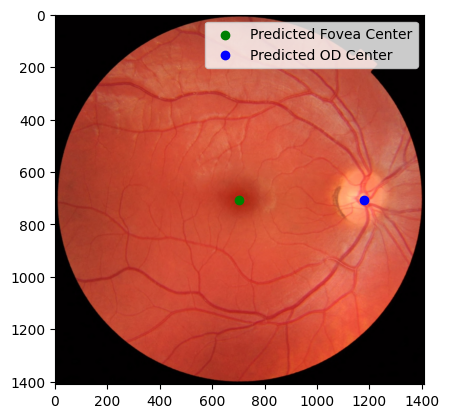

In [7]:
fig, ax = plt.subplots()
ax.imshow(plt.imread(image_path))
ax.scatter(fovea_x, fovea_y, c="g", label="Predicted Fovea Center")
ax.scatter(od_x, od_y, c="b", label="Predicted OD Center")
ax.legend()
plt.show()

Inference for a batch of images

In [8]:
image_paths = [
    "../../fovea_detection/DeepDRiD/regular_fundus_images/regular-fundus-training/Images/197/197_l1.jpg",
    "../../fovea_detection/DeepDRiD/regular_fundus_images/regular-fundus-training/Images/197/197_l2.jpg",
    "../../fovea_detection/DeepDRiD/regular_fundus_images/regular-fundus-training/Images/206/206_l1.jpg",    
    "../../fovea_detection/DeepDRiD/regular_fundus_images/regular-fundus-training/Images/207/207_l2.jpg"
]

In [9]:
# Feed in same sized images of at least 350x350 px
transform = Compose([Resize(350, antialias=True), CenterCrop(350), ToTensor()])

image_batch = torch.stack([transform(Image.open(image_path)) for image_path in image_paths])

print(f"Batch of images: {image_batch.shape}")

Batch of images: torch.Size([4, 3, 350, 350])


In [10]:
labels = model.predict(image_batch)
print("Fovea predictions and OD predictions (fovea_x, fovea_y, od_x, od_y):")
display(labels)

Fovea predictions and OD predictions (fovea_x, fovea_y, od_x, od_y):


[array([301.3441 , 187.27577, 183.51459, 176.70656], dtype=float32),
 array([162.61356, 184.2979 ,  38.46397, 159.61914], dtype=float32),
 array([156.3118 , 180.3105 ,  30.82447, 168.63077], dtype=float32),
 array([168.64305, 176.66591,  38.94498, 158.92616], dtype=float32)]

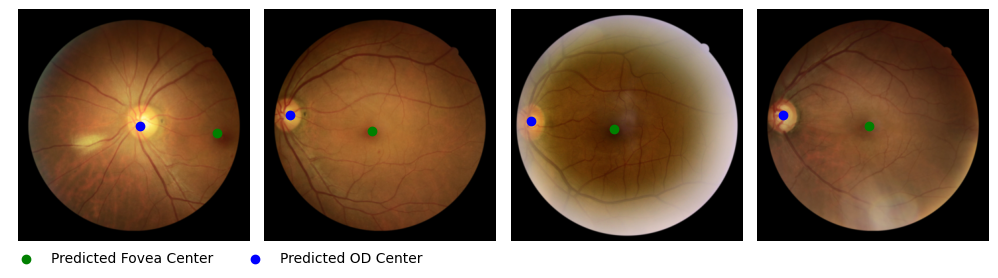

In [11]:
# plot the images with the predicted labels
fig, axs = plt.subplots(1, 4, figsize=(10, 3))

for (image_path, label, ax) in zip(image_paths, labels, axs.flatten()):
    # Make sure to plot the image in the same size as it was fed into the model
    img = transform(Image.open(image_path)).permute(1, 2, 0)
    ax.imshow(img)
    fovea_x, fovea_y, od_x, od_y = label
    ax.scatter(fovea_x, fovea_y, c="g", label="Predicted Fovea Center")
    ax.scatter(od_x, od_y, c="b", label="Predicted OD Center")
    ax.axis("off")

# Add a legend
fig.legend(["Predicted Fovea Center", "Predicted OD Center"], loc="lower left", ncol=2, frameon=False)
plt.tight_layout()
plt.show()
